# Summarize the 

Process the result of grid search inversion and summarize the source properties of gouge-patch source.

2023.10.23 Kurama Okubo

2024.02.09 update for master plot: update M0hat and M0

2024.10.31 update for the merged catalog.

NOTE: We use the VR from the P window. The result of VR for PS is identical to the P because we set `alpha_p=1.0`, `alpha_s=0.0` in the grid search.

In [45]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time

from multiprocessing import Pool, cpu_count
from obspy.signal.cross_correlation import correlate, xcorr_max

from itertools import combinations

from scipy.spatial.distance import euclidean, correlation

%load_ext autoreload
%autoreload 2

from AEevents_Gridsearch_PS_func import *
from AEevents_plot_func import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# datadir
data_inputdir = "../data/07_DATA_MTinversion"

figdir = "../figure/08_summary_VR"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [47]:
expr_id = 87
# event_ids = [3, 16, 17, 30, 51, 52, 58, 61, 77, 91, 99, 106, 21, 32, 35, 67, 90, 97, 104, \
#             24, 36, 41, 43, 46, 70, 71, 81 ,82] # Ordinary, x=1750, rupturetype all (1, 2, and 3) # excluded 37 due to low S/N

event_ids = [4,   9,  18,  19,  20,  21,  24,  27,  30,  31,  37,  38,  40,
        43,  44,  49,  50,  52,  55,  59,  61,  62,  69,  72,  75,
        76,  77,  81,  85,  88,  89,  95,  99, 100, 102, 109, 110, 111,
       118, 120, 126, 128, 129, 131] # excluded 45 (old id:37) due to low S/N 

datacase_list = ["fb03-{:03d}__{:04d}".format(expr_id, x) for x in event_ids]



In [48]:
balldrop_model=4 # 2 for the model only with SiTj, 4 for the SiTjbeta

df_VR_all = pd.read_csv(data_inputdir+"/MTinv_gridsearch_{}_balldropmodel{}.csv".format(datacase_list[11], balldrop_model), index_col=0)

In [49]:
df_VR_all

,Mw,M0hat,M0,rake,TR,VR_P,VR_S,VR_PS,VR_sensors,Nsensor
0,-8.070000,0.001000,0.000707,0,0.000001,-0.001394,0.008967,-0.001394,"('OL07', 'OL08', 'OL23', 'OL22')",6
0,-8.047993,0.001079,0.000763,0,0.000001,-0.001504,0.009666,-0.001504,"('OL07', 'OL08', 'OL23', 'OL22')",6
0,-8.025986,0.001164,0.000823,0,0.000001,-0.001623,0.010418,-0.001623,"('OL07', 'OL08', 'OL23', 'OL22')",6
0,-8.003979,0.001256,0.000888,0,0.000001,-0.001751,0.011227,-0.001751,"('OL07', 'OL08', 'OL23', 'OL22')",6
0,-7.981973,0.001355,0.000958,0,0.000001,-0.001890,0.012099,-0.001890,"('OL07', 'OL08', 'OL23', 'OL22')",6
...,...,...,...,...,...,...,...,...,...,...
0,-5.957341,1.475668,1.043455,0,0.000004,-3.670861,-22.973856,-3.670861,"('OL07', 'OL08', 'OL23', 'OL22')",6
0,-5.935334,1.592205,1.125859,0,0.000004,-4.707284,-27.284354,-4.707284,"('OL07', 'OL08', 'OL23', 'OL22')",6
0,-5.913327,1.717946,1.214771,0,0.000004,-5.948121,-32.345090,-5.948121,"('OL07', 'OL08', 'OL23', 'OL22')",6
0,-5.891320,1.853616,1.310704,0,0.000004,-7.429639,-38.282600,-7.429639,"('OL07', 'OL08', 'OL23', 'OL22')",6


In [14]:
df_bestparam = pd.DataFrame(columns=['VR_P_best', 'M0_best', 'TR_best', 'rake_best'])

for datacase in datacase_list:
#datacase = datacase_list[5]

    # read the MT grid search csv
    df_VR_all = pd.read_csv(data_inputdir+"/MTinv_gridsearch_{}_balldropmodel{}.csv".format(datacase, balldrop_model), index_col=0)

    # load grid search parameters
    with open(data_inputdir+"/GridSearch_param_{}_balldropmodel{}.pickle".format(datacase, balldrop_model),"rb") as fo:
        param = pickle.load(fo)

    # parse M0_range and TR_range
    M0_range = np.unique(df_VR_all["M0"])
    TR_range = np.unique(df_VR_all["TR"])

    zc_P = np.zeros((len(M0_range), len(TR_range)))
    zc_S = np.zeros((len(M0_range), len(TR_range)))
    zc_PS = np.zeros((len(M0_range), len(TR_range)))

    for i, M0_try in enumerate(tqdm(M0_range)): # loop by M0
        for j, TR_try in enumerate(TR_range):

            df_select = df_VR_all[(df_VR_all["M0"] == M0_try) & (df_VR_all["TR"] == TR_try)]

            imax_P = df_select["VR_P"].argmax()
            imax_S = df_select["VR_S"].argmax()
            imax_PS = df_select["VR_PS"].argmax()

            VR_P_max = df_select.iloc[imax_P]["VR_P"]
            VR_S_max = df_select.iloc[imax_S]["VR_S"]
            VR_PS_max = df_select.iloc[imax_PS]["VR_PS"]

            zc_P[i, j] =  VR_P_max
            zc_S[i, j] =  VR_S_max
            zc_PS[i, j] =  VR_PS_max

    # extract best VR parameters
    max_M0_P, max_TR_P = np.unravel_index(zc_P.argmax(), zc_P.shape)
    best_M0_P = M0_range[max_M0_P]
    best_TR_P = TR_range[max_TR_P]
    df_best_P = df_VR_all[(df_VR_all["M0"] == best_M0_P) & (df_VR_all["TR"] == best_TR_P)]
    print(f"{datacase} best M0:{best_M0_P:.3f}[J], best TR:{best_TR_P*1e6:.3f}[us]")

    # Plot VR contour
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    cmap="viridis"

    vmax_P = df_best_P["VR_P"].values[0] #0.6
    vmin_P = 0.8*vmax_P
    Nlevel = np.hstack([-np.inf, np.linspace(vmin_P, vmax_P, 201)])

    h3 = ax.contourf(M0_range, TR_range*1e6, zc_P.transpose(), Nlevel, vmin=vmin_P, vmax=vmax_P, cmap=cmap)
    for c in h3.collections:
        c.set_rasterized(True)
        
#     ax.set_title(f"P window used: best VR:{vmax_P:.2f}\n"+f"{datacase} best M0:{best_M0_P:.3f}[J], best TR:{best_TR_P*1e6:.1f}[us]", fontsize=12)
    gougeevent_id = int(datacase.split("__")[1])
    ylabelstr = "$\mathrm{M_0}$"
    title_str = f"Event ID:{gougeevent_id:d}\nmax VR:{vmax_P:.2f} {ylabelstr:s}:{best_M0_P:.2f} Nm $T_R$:{best_TR_P*1e6:.1f} μs"
    ax.set_title(title_str, fontsize=12)
#     contour_level_P = [contour_coef*np.max(zc_P)]
    ax.plot(best_M0_P, best_TR_P*1e6, "+", ms=15, c="k", markeredgewidth=2)
    
    cb_P = fig.colorbar(ScalarMappable(norm=h3.norm, cmap=h3.cmap), ax=ax, 
       ticks=np.linspace(vmin_P, vmax_P, 5), orientation="horizontal")
    cb_P.set_label("VR")

    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    plot_twincbar(cb_P, vmax_P)

    ax.set_xscale('log')
    ax.set_xlim([1e-3, 1.2])
    ax.set_xlabel("M0 [J]") 
    ax.set_aspect(1.0, adjustable='box')
    ax.xaxis.set_label_coords(0.5, -0.07)

    # ax.set_xlabel("M0 [J]") 
    ax.set_ylabel("Source duration [μs]") 

    # plt.tight_layout()
    plt.savefig(figdir + "/VR_P_{}_fix_ccshift.jpg".format(datacase), dpi=80, bbox_inches="tight")
    plt.savefig(figdir + "/VR_P_{}_fix_ccshift.pdf".format(datacase), bbox_inches="tight")
    
    # concat the best M0 and TR datasheet
    
    df_bestparam = pd.concat([df_bestparam, pd.DataFrame([[vmax_P, best_M0_P, best_TR_P*1e6, 0]],
                                           columns=['VR_P_best', 'M0_best', 'TR_best', 'rake_best'], index=[datacase])])

    plt.clf()
    plt.close()

100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 63.08it/s]


fb03-087__0004 best M0:0.568[J], best TR:3.300[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 53.73it/s]


fb03-087__0009 best M0:0.046[J], best TR:3.100[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 61.56it/s]


fb03-087__0018 best M0:0.613[J], best TR:3.500[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.45it/s]


fb03-087__0019 best M0:0.050[J], best TR:3.100[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 62.08it/s]


fb03-087__0020 best M0:0.770[J], best TR:3.300[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.90it/s]


fb03-087__0021 best M0:0.023[J], best TR:3.000[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 56.02it/s]


fb03-087__0024 best M0:0.063[J], best TR:3.100[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.45it/s]


fb03-087__0027 best M0:0.770[J], best TR:3.300[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 61.74it/s]


fb03-087__0030 best M0:0.058[J], best TR:3.300[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 62.00it/s]


fb03-087__0031 best M0:0.896[J], best TR:3.200[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.55it/s]


fb03-087__0037 best M0:0.025[J], best TR:3.800[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 63.28it/s]


fb03-087__0038 best M0:0.287[J], best TR:2.800[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 63.87it/s]


fb03-087__0040 best M0:0.246[J], best TR:2.800[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.22it/s]


fb03-087__0043 best M0:0.196[J], best TR:3.200[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 62.05it/s]


fb03-087__0044 best M0:0.068[J], best TR:3.200[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.06it/s]


fb03-087__0049 best M0:0.040[J], best TR:2.900[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 63.93it/s]


fb03-087__0050 best M0:0.334[J], best TR:3.500[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.16it/s]


fb03-087__0052 best M0:0.452[J], best TR:3.400[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 63.96it/s]


fb03-087__0055 best M0:0.360[J], best TR:3.300[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.21it/s]


fb03-087__0059 best M0:0.079[J], best TR:3.600[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 63.06it/s]


fb03-087__0061 best M0:0.714[J], best TR:3.300[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.45it/s]


fb03-087__0062 best M0:0.568[J], best TR:3.300[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 63.85it/s]


fb03-087__0069 best M0:0.334[J], best TR:2.900[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 62.30it/s]


fb03-087__0072 best M0:0.770[J], best TR:3.300[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.15it/s]


fb03-087__0075 best M0:0.287[J], best TR:3.000[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 63.89it/s]


fb03-087__0076 best M0:0.360[J], best TR:2.800[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.15it/s]


fb03-087__0077 best M0:0.568[J], best TR:3.000[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.32it/s]


fb03-087__0081 best M0:0.054[J], best TR:3.100[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 63.37it/s]


fb03-087__0085 best M0:0.526[J], best TR:2.900[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.11it/s]


fb03-087__0088 best M0:0.967[J], best TR:3.100[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.73it/s]


fb03-087__0089 best M0:0.526[J], best TR:3.300[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 63.80it/s]


fb03-087__0095 best M0:0.770[J], best TR:3.400[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.41it/s]


fb03-087__0099 best M0:0.613[J], best TR:3.600[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.07it/s]


fb03-087__0100 best M0:0.452[J], best TR:3.100[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.28it/s]


fb03-087__0102 best M0:0.099[J], best TR:3.300[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.34it/s]


fb03-087__0109 best M0:0.419[J], best TR:3.000[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 62.11it/s]


fb03-087__0110 best M0:0.058[J], best TR:3.700[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.97it/s]


fb03-087__0111 best M0:0.452[J], best TR:3.000[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.66it/s]


fb03-087__0118 best M0:0.099[J], best TR:2.800[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 63.49it/s]


fb03-087__0120 best M0:0.568[J], best TR:3.400[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.20it/s]


fb03-087__0126 best M0:0.023[J], best TR:2.800[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.26it/s]


fb03-087__0128 best M0:0.015[J], best TR:3.100[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 63.83it/s]


fb03-087__0129 best M0:0.967[J], best TR:3.300[us]


100%|█████████████████████████████████████████| 101/101 [00:01<00:00, 64.31it/s]


fb03-087__0131 best M0:0.661[J], best TR:2.700[us]


In [15]:
M0_range.min(), M0_range.max()

(0.00070711, 1.41421356)

In [16]:
df_best_P

,Mw,M0hat,M0,rake,TR,VR_P,VR_S,VR_PS,VR_sensors,Nsensor
0,-6.089382,0.935248,0.661321,0,0.000003,0.852948,-1.145193,0.852948,"('OL07', 'OL08', 'OL23', 'OL22')",6


In [17]:
df_bestparam

,VR_P_best,M0_best,TR_best,rake_best
fb03-087__0004,0.892496,0.568056,3.3,0
fb03-087__0009,0.730114,0.046244,3.1,0
fb03-087__0018,0.866794,0.612917,3.5,0
fb03-087__0019,0.789837,0.049896,3.1,0
fb03-087__0020,0.890390,0.769897,3.3,0
fb03-087__0021,0.880472,0.023332,3.0,0
fb03-087__0024,0.836420,0.062675,3.1,0
fb03-087__0027,0.906336,0.769897,3.3,0
fb03-087__0030,0.587996,0.058087,3.3,0
fb03-087__0031,0.897995,0.896300,3.2,0


In [18]:
df_bestparam.to_csv(f"../data/datacsv/gridsearch_bestparam_M0andTR_{datacase.split('__')[0]}.csv", float_format='%8.2f')

In [19]:
print(f"median of best M0: {np.round(df_bestparam['M0_best'].median(), 4)} [J]")
print(f"median with removing small events M0rem: {np.round(df_bestparam[df_bestparam['M0_best'] > 0.3].median()[0], 4)} [J]")

median of best M0: 0.36 [J]
median with removing small events M0rem: 0.8827 [J]


In [20]:
M02Mw(0.76)

-6.149457605146139

# Plot histogram of best M0

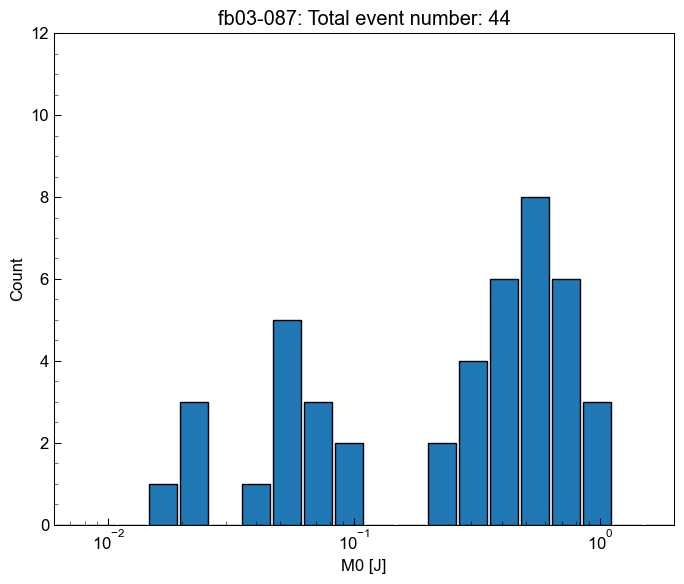

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
bins = np.logspace(np.log10(0.006), np.log10(2.0), 21) 

# bins=10

ax.hist(df_bestparam["M0_best"], bins=bins, rwidth=0.9, ec='k')

ax.set_xscale('log')
ax.set_xlabel("M0 [J]") 
ax.set_ylabel("Count") 
ax.set_xlim([0.006, 2.0])
ax.set_ylim([0, 12]) 
ax.set_title(f"fb03-{expr_id:03d}: Total event number: {len(event_ids)}")

fig.tight_layout()
plt.savefig(figdir + f"/hist_eventmagnitude_fb03-{expr_id:03d}.jpg", dpi=80, bbox_inches="tight")